In [1]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np

In [2]:
NUM_CLASSES = 15

def create_model():
    """Creates the DenseNet121 model.

    Returns:
        Model: The DenseNet121 model.
    """
    # Load the DenseNet121 model
    base_model = DenseNet121(weights='imagenet', include_top=False)

    # Add a global spatial average pooling layer

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Add a fully connected layer
    x = Dense(1024, activation='relu')(x)

    # Add a logistic layer
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    # Model to train
    model = Model(inputs=base_model.input, outputs=predictions)

        
    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
    


In [3]:
def train_model(model, test_path, validation_path, epochs=1):
    """Trains the model

    Args:
        model (Model): DenseNet121 model
        test_path (str): path to the test dataset
        validation_path (str): path to the validation dataset
        epochs (int): epochs to train the model
        
    Return: History

    """
    train_dataset = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_dataset = train_dataset.flow_from_directory(      test_path,
                                                            target_size=(256, 256),
                                                            batch_size=32,
                                                            class_mode='categorical')

    validation_dataset = ImageDataGenerator(preprocessing_function=preprocess_input)

    validation_dataset = validation_dataset.flow_from_directory(validation_path,
                                                            target_size=(256, 256),
                                                            batch_size=32,
                                                            class_mode='categorical')

    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=validation_dataset,
        batch_size=32,
        verbose="auto"
    )
    
    return history


In [4]:
def evaluate_model(model):
    """Evaluates the model

    Args:
        model (Model): The model to evaluate

    Returns:
        ndarray: loss and accuracy respectively
    """
    validation_dataset = ImageDataGenerator(preprocessing_function=preprocess_input)

    validation_dataset = validation_dataset.flow_from_directory('../../Baseline_Training_Set/test/',
                                                            target_size=(256, 256),
                                                            batch_size=32,
                                                            class_mode='categorical')

    evaluation = model.evaluate(
        validation_dataset,
        batch_size=32,
        verbose="auto"
    )

    return evaluation

In [5]:
def make_confusion_matrix(model, test_path):
    """Makes the confusion matrix for a model

    Args:
        model (Model): Model
        test_path (str): Path to the test dataset

    Returns:
        ndarray: Confusion matrix
    """
    validation_dataset = ImageDataGenerator(preprocessing_function=preprocess_input)
    validation_dataset = validation_dataset.flow_from_directory(test_path,
                                                            target_size=(256, 256),
                                                            batch_size=32,
                                                            class_mode='categorical',
                                                            shuffle=False)
                                                            
    validation_predictions = model.predict(validation_dataset)
    processed_validation_predictions = np.argmax(validation_predictions, axis=-1)

    matrix = np.array(tf.math.confusion_matrix(
    validation_dataset.classes,
    processed_validation_predictions,
    ))

    return matrix
    

In [6]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(matrix, class_names):
    """Makes a plot for the confusion matrix

    Args:
        matrix (numpy.ndarray): Confusion matrix
        class_names (list): A list of strings representing the class names in the order of the matrixs
    """

    plt.figure(figsize=(12, 10))

    plt.imshow(matrix, cmap='Blues')
    plt.colorbar()

    # Add labels to the plot
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)

    # Add a title and x and y labels
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")

    # Add grid lines
    plt.grid(False)


    # Add text to the cells
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, matrix[i, j], horizontalalignment="center", color="black")
    plt.savefig('confusion_matrix.png')
    plt.show()


In [7]:
def plot_accuracy(history):
    """Plots the accuracy for the training and validation data

    Args:
        history (History): History object
    """
    plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'])
    plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('accuracy.png')
    plt.show()

In [8]:
def plot_loss(history):
    """Plots the loss for the training and validation data

    Args:
        history (History): History object
    """
    plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'])
    plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('loss.png')
    plt.show()

In [ ]:

model = create_model()
history = train_model(model,'../../baseline_trainingset_split/train/','../../baseline_trainingset_split/val/',  8)
matrix = make_confusion_matrix(model, '../../baseline_trainingset_split/test/')


class_names = [
    "Appendicularia",
    "Bivalve",
    "Ceratium",
    "Ciliate",
    "Clumps",
    "Copepod",
    "Copepod egg clump",
    "Detritus",
    "Diatom",
    "Dinoflagellate",
    "Dinophysis",
    "Foraminifera",
    "Gastropoda",
    "Protoperidinium",
    "Silicoflagellate"
]
plot_confusion_matrix(matrix, class_names=class_names)



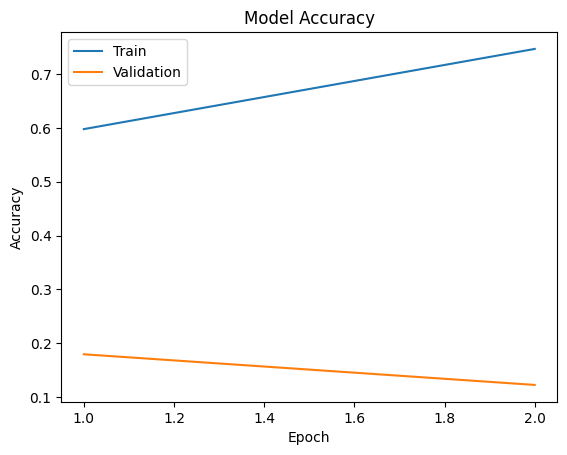

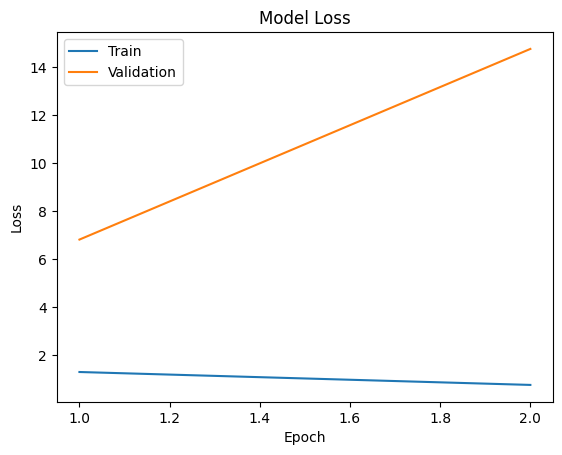

In [24]:
plot_accuracy(history)
plot_loss(history)